In [1]:
from imutils import face_utils
import cv2
import numpy as np
import dlib

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()

key = os.getenv("API_KEY")

In [3]:
import requests
import json

api_call = (
    f"https://www.rijksmuseum.nl/api/en/collection?"
    f"key={key}"
    "&imgonly=True"
    "&type=painting"
    "&q=portrait"
)

r = requests.get(api_call)
data = json.loads(r.text)

In [4]:
ex_img_url = data["artObjects"][2]["webImage"]["url"]

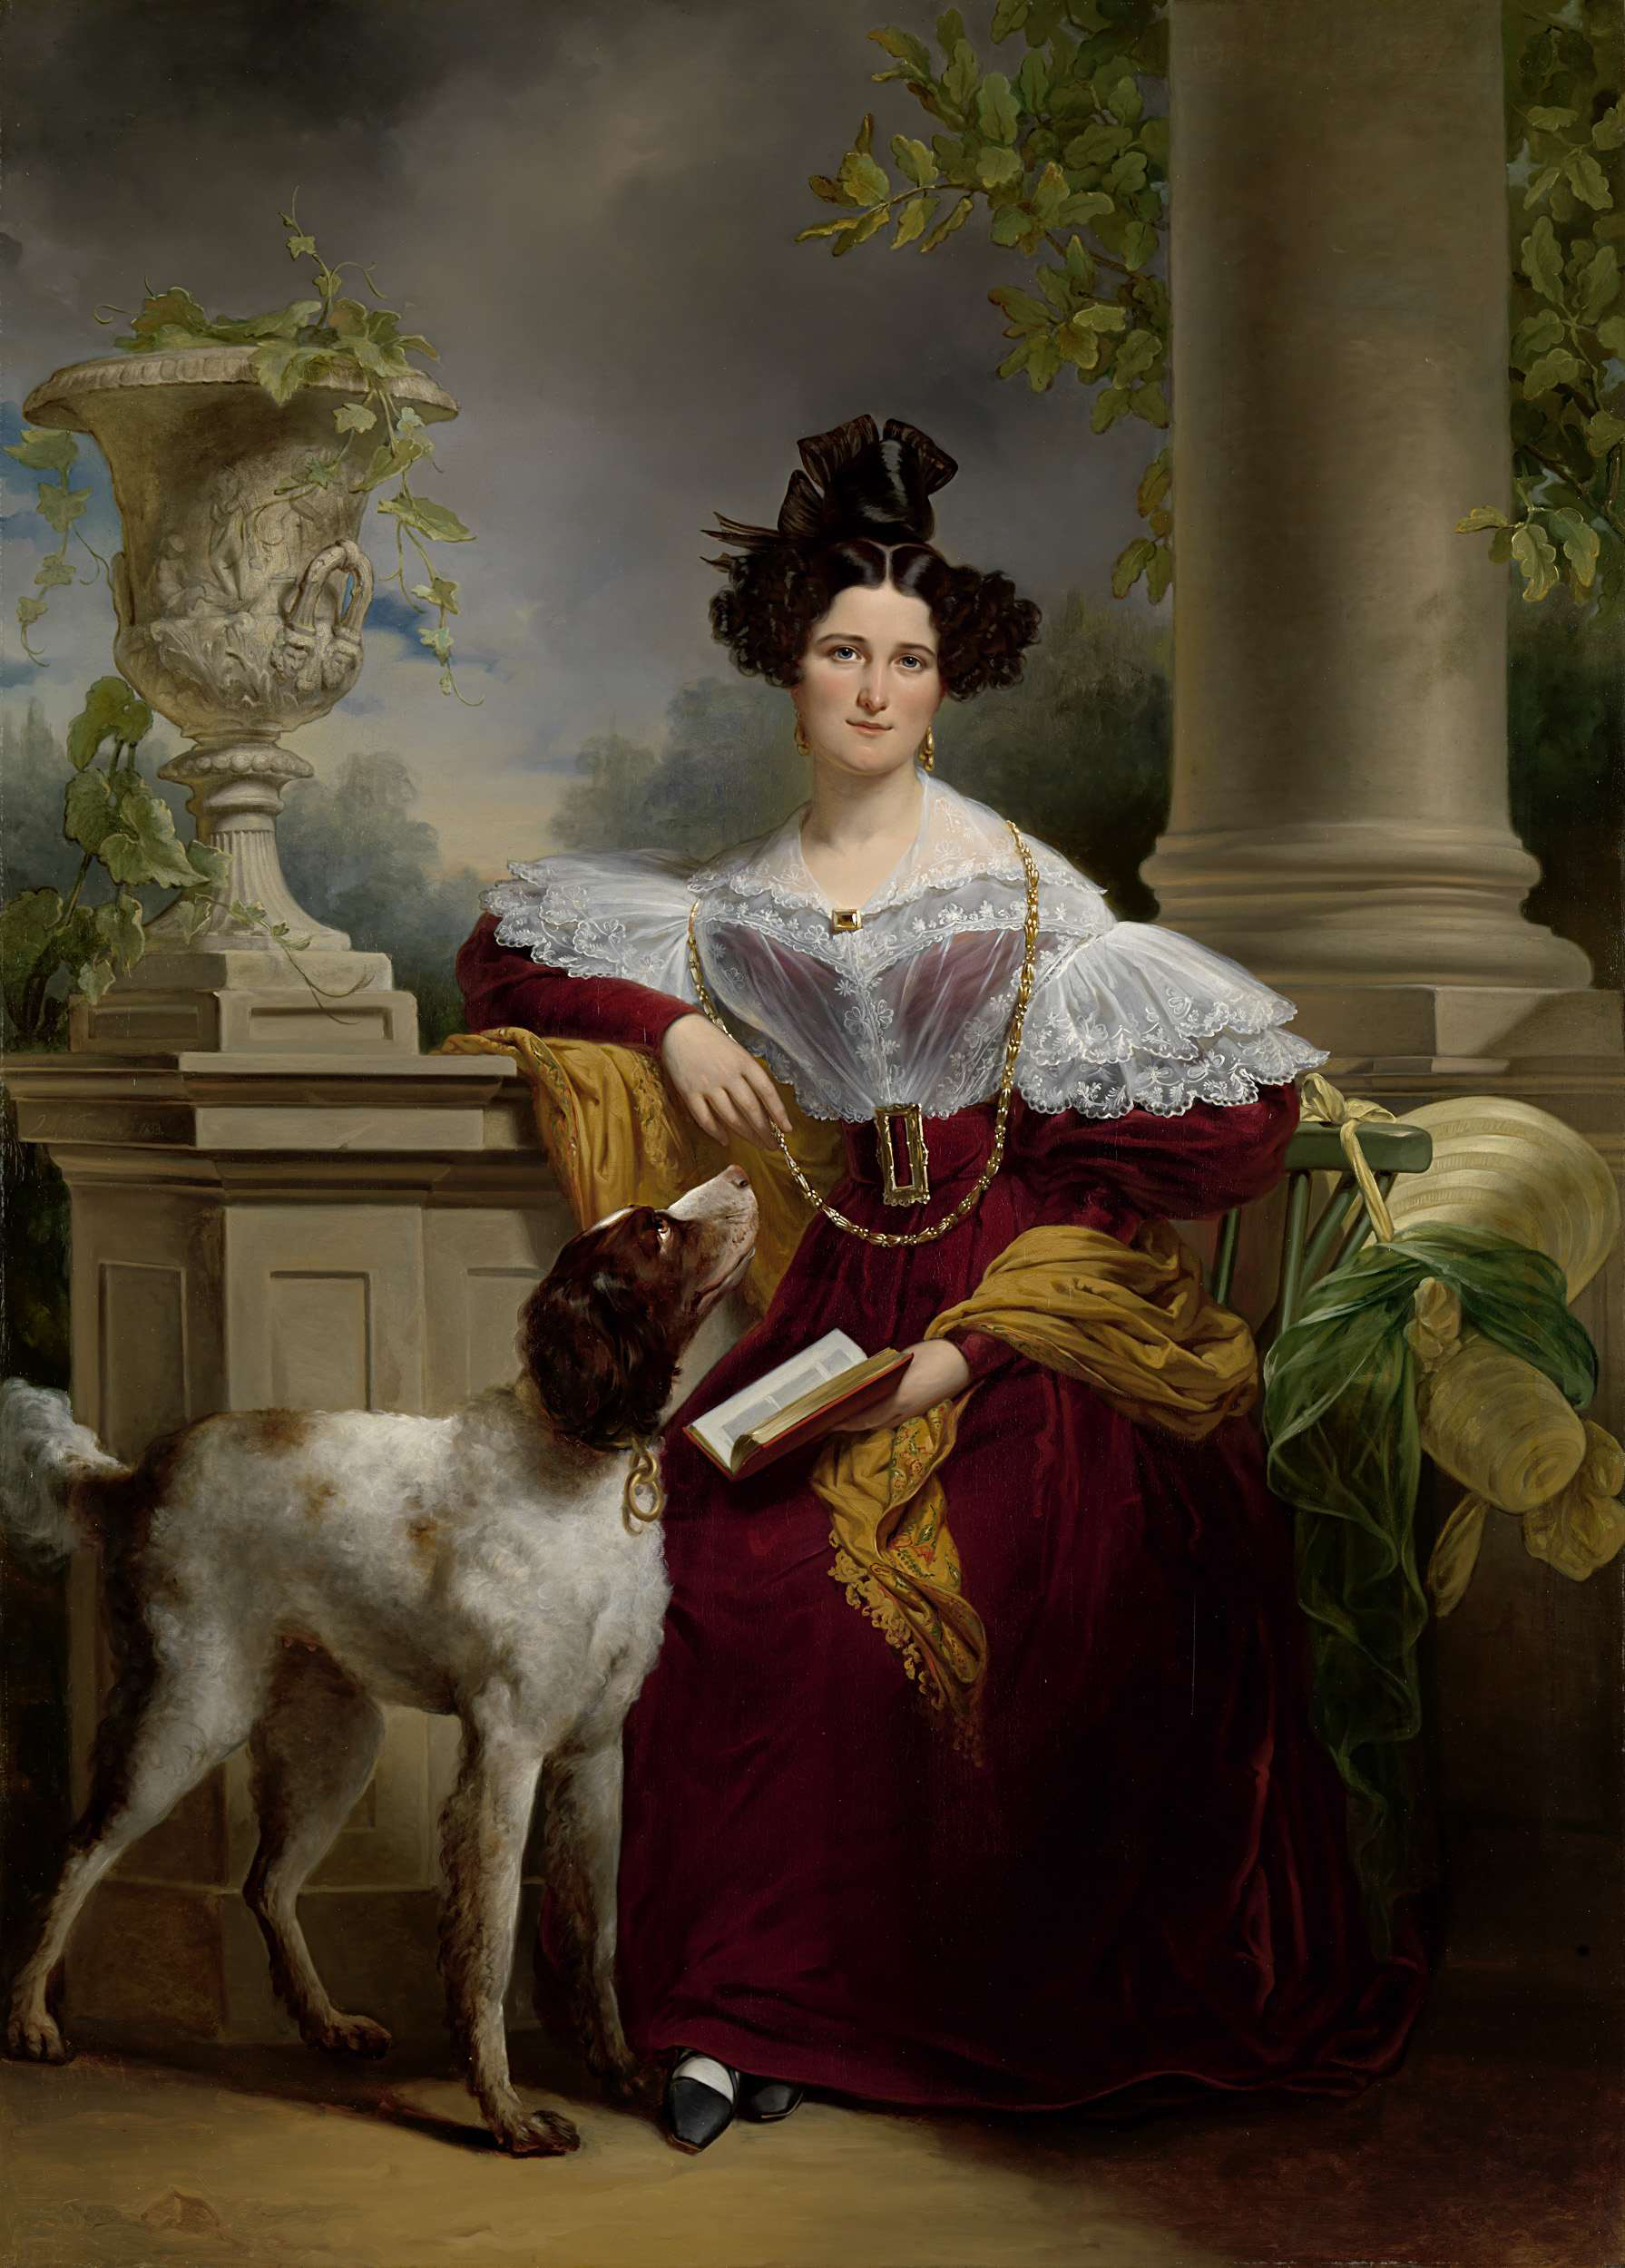

In [5]:
from io import BytesIO
from PIL import Image

r = requests.get(ex_img_url)
img = Image.open(BytesIO(r.content))
img.show()

In [6]:
def detect_face(img):

    img = np.array(img)

    p = "shape_predictor_68_face_landmarks.dat"

    detector = dlib.get_frontal_face_detector()

    predictor = dlib.shape_predictor(p)

    gray = cv2.cvtColor(img, code=cv2.COLOR_BGR2GRAY)

    faces = detector(gray)
    for face in faces:
        x1 = face.left() # left point
        y1 = face.top() # top point
        x2 = face.right() # right point
        y2 = face.bottom() # bottom point

        print((x1, y1), (x2, y2))
        # Create landmark object
        landmarks = predictor(image=gray, box=face)

        # Loop through all the points
        # 36 - 41
        # 42 - 47
        # 48 - 59
        for n in range(36, 60):
            x = landmarks.part(n).x
            y = landmarks.part(n).y

            # Draw a circle
            cv2.circle(img=img, center=(x, y), radius=2, color=(0, 255, 0), thickness=-1)

        img = img[y1-10:y2+10, x1-10:x2+10]

    Image.fromarray(img, "RGB").show()

(871, 672) (1050, 851)


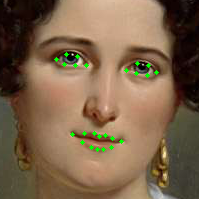

In [7]:
detect_face(img)

In [8]:
def get_face_data(url):
    r = requests.get(url)
    
    img = Image.open(BytesIO(r.content))
    img = np.array(img)

    p = "shape_predictor_68_face_landmarks.dat"

    detector = dlib.get_frontal_face_detector()

    predictor = dlib.shape_predictor(p)

    gray = cv2.cvtColor(img, code=cv2.COLOR_BGR2GRAY)

    faces = detector(gray)
    if faces:
        face = faces[0]
        
        # Create landmark object
        landmarks = predictor(image=gray, box=face)

        points = {}
        
        points["box"] = {
            "left":    face.left() - 10,
            "right":   face.right() + 10,
            "top":     face.top() - 10,
            "bottom":  face.bottom() + 10,
        }
        
        get_points = lambda a, b: [
            [landmarks.part(n).x, landmarks.part(n).y] 
            for n in range(a, b+1)
        ]
        
        points["leftEye"] = get_points(36, 41)
        points["rightEye"] = get_points(42, 47)
        points["mouth"] = get_points(48, 59)
        
        return points
    
    else:
        return None

In [9]:
get_face_data(ex_img_url)

{'box': {'left': 861, 'right': 1060, 'top': 662, 'bottom': 861},
 'leftEye': [[917, 721],
  [927, 716],
  [938, 718],
  [947, 727],
  [936, 727],
  [925, 726]],
 'rightEye': [[987, 732],
  [998, 725],
  [1009, 727],
  [1017, 734],
  [1008, 737],
  [997, 735]],
 'mouth': [[933, 796],
  [945, 795],
  [955, 795],
  [960, 798],
  [966, 797],
  [973, 800],
  [982, 803],
  [972, 809],
  [964, 811],
  [958, 811],
  [952, 809],
  [943, 804]]}

In [10]:
num_pages = data["count"] // 10

img_urls = []

for page in range(1, num_pages+1):
    url = api_call + f"&p={page}"
    data = json.loads(requests.get(url).text)
    imgs = [o["webImage"]["url"] for o in data["artObjects"]]
    img_urls += imgs

In [11]:
assert len(img_urls) == data["count"]

In [12]:
face_data = []
for url in img_urls:
    fd = get_face_data(url)
    if fd:
        d = {"url": url}
        d.update(fd)
        face_data.append(d)
    
face_data[0]

{'url': 'https://lh5.ggpht.com/P5o0tug6fqYu5WAV1L8wObu37HGOGrwgRuGLhkx9Ban89a6PwwUOA2uTSEllOUN_S33pBoJi7NoFcMsw89guz14O8TY=s0',
 'box': {'left': 861, 'right': 1060, 'top': 662, 'bottom': 861},
 'leftEye': [[917, 721],
  [927, 716],
  [938, 718],
  [947, 727],
  [936, 727],
  [925, 726]],
 'rightEye': [[987, 732],
  [998, 725],
  [1009, 727],
  [1017, 734],
  [1008, 737],
  [997, 735]],
 'mouth': [[933, 796],
  [945, 795],
  [955, 795],
  [960, 798],
  [966, 797],
  [973, 800],
  [982, 803],
  [972, 809],
  [964, 811],
  [958, 811],
  [952, 809],
  [943, 804]]}

In [13]:
with open("../data/rijks-faces.json", "w") as f:
    json.dump(face_data, f)